# Analysis of domain name popularity in African countries

We scraped the data from https://www.alexa.com/topsites/countries. To be able to retrieve historical data, we used the Way back Machine downloader https://github.com/hartator/wayback-machine-downloader.

We retrieved Alexa top 50 pages from 2009 to 2019.

In this analysis, we are going to study 5 African countries namely: South Africa, Nigeria, Kenya, Egypt and DRC

## Part 1: Parsing the data

In [529]:
import numpy as np
import pandas as pd
from datetime import datetime
from scipy import stats

import itertools

import matplotlib.pyplot as plt

wa = ['BF','BJ','CI','CV','GH','GM','GN','GW','LR','ML','NE','NG','SL','SN','TD','TG']
ea = ['BI','DJ','ER','ET','KE','RW','SO','TZ','UG']
na = ['DZ','EG','EH','LY','MA','MR','SD','SS','TN']
sa = ['AO','BW','LS','MW','MZ','NA','SZ','ZA','ZM','ZW']
ca = ['CD','CF','CG','CM','GA','GQ','ST']
io = ['KM','MG','MU','RE','SC','YT']

ccs = [
'EG', 'BJ', 'CI', 'CV', 'GH', 'GM', 'GN', 'GW', 'AO', 'CF', 'CG', 'CM', 'GA', 'GQ', 'TD', 'BI', 'DJ', 'ER', 'ET', 'KM', 'BW', 'MA', 'SD', 'TN', 'LR', 'ML', 'MR', 'NE', 'NG', 'SL', 'SN', 'TG', 'ST', 'KE', 'MG', 'MU', 'MW', 'MZ', 'RE', 'RW', 'SC', 'SO', 'UG', 'LS', 'NA', 'SZ', 'ZA', 'DZ', 'EH', 'LY', 'BF', 'SH', 'CD', 'TZ', 'YT', 'ZM', 'ZW']

In [530]:
df = pd.read_csv('data/alexatop50/alexatop50_2009_2019_raw.csv', keep_default_na=False)
df['name'] = df.apply(lambda x: x.domain.split('.')[0], axis=1)
df['date'] = pd.to_datetime(df['date'])
df['year'] = pd.DatetimeIndex(df['date']).year
df.sort_values(by=['date','cc','ranking'], inplace=True)
#df = df.loc[df.ranking < 51] ##only take the top50
#df.drop_duplicates(['date','name'], keep='first', inplace=True)
#df.index = df['date'] 
df.to_csv('data/alexatop50/alexatop50_2009_2019.csv', index=False)
df.loc[df.cc == 'NA'].head()

,date,ranking,domain,cc,name,year
241903,2017-05-19 14:52:49,1,google.com.na,NA,google,2017
241904,2017-05-19 14:52:49,2,google.com,NA,google,2017
241905,2017-05-19 14:52:49,3,youtube.com,NA,youtube,2017
241906,2017-05-19 14:52:49,4,facebook.com,NA,facebook,2017
241907,2017-05-19 14:52:49,5,yahoo.com,NA,yahoo,2017


## Part 2: Some first plots of popularity
First we need to compute the median ranking by year. We select only the top10 websites i.e. we select only rows with 

In [531]:
df_count = df.groupby([df.year], as_index=False)[['name']].count()
df_count

,year,name
0,2009,541
1,2010,792
2,2011,3928
3,2013,343
4,2014,1656
5,2015,2126
6,2016,6468
7,2017,37007
8,2018,19660
9,2019,176146


In [532]:
#df_top_10 = df[df.ranking < 21]
df_median = df.groupby([df.name, df.year], as_index=False)[['ranking']].median()
df_mode = df.groupby([df.name, df.year], as_index=False)[['ranking']].agg(lambda x: pd.Series.mode(x)[0])
df_mode.head()

,name,year,ranking
0,aabbir,2016,23
1,aabbir,2017,29
2,aabbir,2018,28
3,aabbir,2019,37
4,aau,2017,28


In [533]:
df_median.sort_values(by=['year','ranking'],ascending=True, inplace=True)
df_mode.sort_values(by=['year','ranking'],ascending=True, inplace=True)

In [534]:
allyears_indexed = df_mode.set_index(['name', 'year']).sort_index()
allyears_indexed.head()

ranking
name   year         
aabbir 2016       23
       2017       29
       2018       28
       2019       37
aau    2017       28

In [535]:
allyears_indexed.loc['live'].index

Int64Index([2009, 2010, 2011, 2013, 2014, 2015, 2016, 2017, 2018, 2019], dtype='int64', name='year')

In [536]:
def plotname(name):
    data = allyears_indexed.loc[name]
    plt.plot(data.index, data.values)

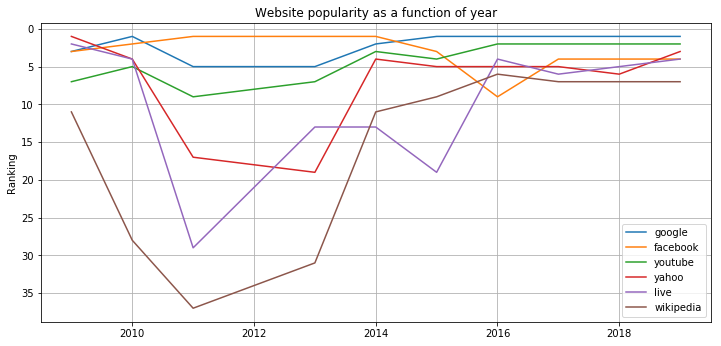

In [558]:
plt.figure(figsize = (12, 5.5))

names = ['google', 'facebook', 'youtube', 'yahoo', 'live', 'wikipedia']

for name in names:
    plotname(name)

plt.legend(names)
plt.grid()
plt.gca().invert_yaxis()
plt.title('Website popularity as a function of year')
plt.ylabel('Ranking')
plt.show()

## Stacked plots

In [559]:
variants = allyears_indexed.loc[names].unstack(level = 0, fill_value = 0)
variants

ranking                                    
name facebook google live wikipedia yahoo youtube
year                                             
2009        3      3    2        11     1       7
2010        2      1    4        28     4       5
2011        1      5   29        37    17       9
2013        1      5   13        31    19       7
2014        1      2   13        11     4       3
2015        3      1   19         9     5       4
2016        9      1    4         6     5       2
2017        4      1    6         7     5       2
2018        4      1    5         7     6       2
2019        4      1    4         7     3       2

In [560]:
variants = variants.reindex(columns = names, level = 1)
variants

ranking                                      
name  google facebook youtube yahoo live wikipedia
year                                              
2009       3        3       7     1    2        11
2010       1        2       5     4    4        28
2011       5        1       9    17   29        37
2013       5        1       7    19   13        31
2014       2        1       3     4   13        11
2015       1        3       4     5   19         9
2016       1        9       2     5    4         6
2017       1        4       2     5    6         7
2018       1        4       2     6    5         7
2019       1        4       2     3    4         7

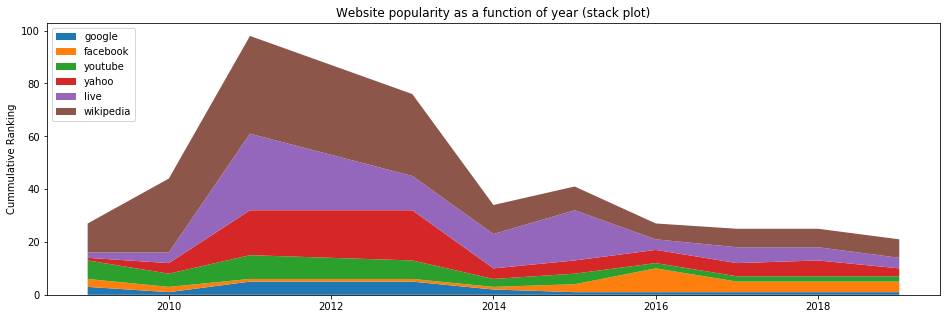

In [561]:
plt.figure(figsize = (16, 5))

plt.stackplot(variants.index, variants.values.T, labels = names)
plt.legend(loc = 'upper left')
plt.title('Website popularity as a function of year (stack plot)')
plt.ylabel('Cummulative Ranking')
#plt.gca().invert_yaxis()
plt.show()

### CDF plots

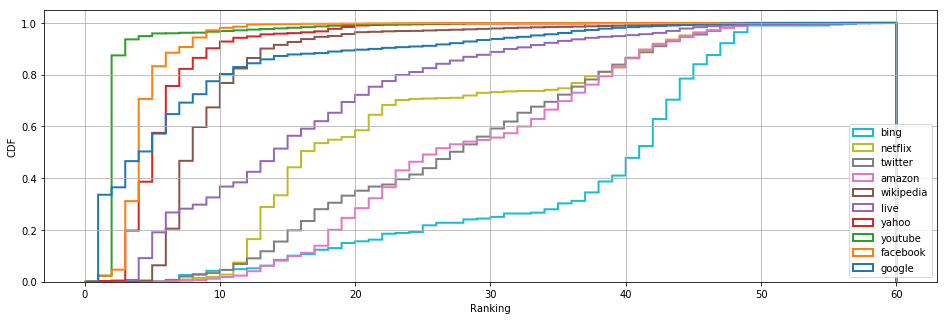

In [563]:
n_bins = 5000

fig, ax1 = plt.subplots(figsize=(16, 5))

names = ['google', 'facebook', 'youtube', 'yahoo', 'live', 'wikipedia', 'amazon', 'twitter', 'netflix', 'bing']

linestyles = ['solid','dashed']
#plot the cumulative histogram
n, bins, patches = ax1.hist([df.loc[df.name == 'google'].ranking.values, 
                            df.loc[df.name == 'facebook'].ranking.values, 
                            df.loc[df.name == 'youtube'].ranking.values,
                            df.loc[df.name == 'yahoo'].ranking.values,
                             df.loc[df.name == 'live'].ranking.values,
                             df.loc[df.name == 'wikipedia'].ranking.values,
                             df.loc[df.name == 'amazon'].ranking.values,
                             df.loc[df.name == 'twitter'].ranking.values,
                             df.loc[df.name == 'netflix'].ranking.values,
                             df.loc[df.name == 'bing'].ranking.values
                            ], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,60],
                           cumulative=True, label=names)
                                    
# tidy up the figure
ax1.grid(True)
ax1.legend(loc='lower right')
#ax1.set_title('Web URL')
ax1.set_xlabel('Ranking')
ax1.set_ylabel('CDF')

plt.savefig("plots/CDF_Website_ranking.pdf")
plt.show()

## Part 3: Yearly top ten websites
The following function sorts a given year's data by popularity and keeps only the top ten websites and ranking.

In [569]:
df_top10 = df.groupby([df.cc, df.name, df.year], as_index=False)[['ranking']].agg(lambda x: pd.Series.mode(x)[0])
df_top10.head()

,cc,name,year,ranking
0,AO,abola,2016,11
1,AO,abola,2017,12
2,AO,abola,2018,10
3,AO,abola,2019,11
4,AO,academia,2019,40


### topten by region

In [625]:
def topten(df, countries, years):
    array = []
    for year in years:
        #select by year and where cc is in region, sort by ranking
        df_res = df.loc[(df.year == year) & (df.cc.isin(countries))].sort_values(by='ranking',ascending=True)
        if (len(df_res) == 0):
            continue
        #select only name column and drop duplicates, also reset the index
        df_res = df_res.iloc[:,[1]].drop_duplicates().reset_index(drop=True)
        df_res.index = df_res.index + 1
        df_res.columns = [year]
        array.append(df_res[:10])
        
    return pd.concat(array, axis = 1)

In [638]:
def plotPopular(set):
    plt.figure(figsize=(12,2.5))

    for name in set:
        plotname(name)

    plt.legend(set)
    plt.title('The five most persistently popular websites from 2009 to 2019')
    plt.ylabel('Ranking')
    plt.gca().invert_yaxis()
    plt.show()


#### All of Africa

In [634]:
df_top10_af = topten(df_top10, ccs, range(2009,2020))
df_top10_af

,2009,2010,2011,2013,2014,2015,2016,2017,2018,2019
1,google,facebook,facebook,google,yahoo,google,google,youtube,youtube,google
2,yahoo,google,yahoo,facebook,google,facebook,youtube,google,google,youtube
3,live,yahoo,google,youtube,facebook,youtube,facebook,yahoo,caasimada,chouftv
4,facebook,youtube,youtube,yahoo,youtube,yahoo,yahoo,facebook,zimeye,yahoo
5,skyrock,live,live,live,hespress,hespress,onclickads,defimedia,facebook,facebook
6,msn,kooora,abidjan,alnilin,blogspot,ask,lexpress,hespress,tuko,defimedia
7,youtube,msn,leboncoin,ouedkniss,ask,mosaiquefm,jumia,tuko,yahoo,ouedkniss
8,sobika,wikipedia,bbc,blogspot,linkedin,avito,seneweb,standardmedia,hespress,abola
9,maktoob,abidjan,seneweb,gumtree,amazon,alnaharegypt,zimeye,zimeye,igihe,caasimada
10,kooora,myegy,ghanaweb,ask,twitter,el-balad,abola,ghanaweb,defimedia,nyasatimes


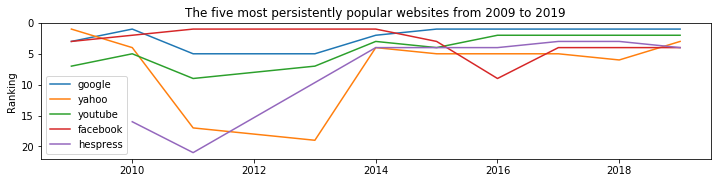

In [639]:
popular = df_top10_af.stack().value_counts().index[:5]
plotPopular(popular)

#### Western Africa

In [646]:
df_top10_wa = topten(df_top10, wa, range(2009,2020))
df_top10_wa

,2009,2010,2011,2013,2014,2015,2016,2017,2018,2019
1,live,facebook,facebook,facebook,google,google,google,google,google,google
2,yahoo,yahoo,google,google,facebook,facebook,youtube,youtube,youtube,youtube
3,google,google,yahoo,yahoo,yahoo,yahoo,facebook,yahoo,yahoo,yahoo
4,facebook,live,youtube,youtube,youtube,youtube,yahoo,facebook,facebook,facebook
5,msn,youtube,abidjan,blogspot,blogspot,jumia,abola,ghanaweb,seneweb,seneweb
6,youtube,abidjan,ghanaweb,nairaland,ask,ask,jumia,seneweb,ghanaweb,ghanaweb
7,abidjan,msn,blogspot,mywebsearch,twitter,ghanaweb,seneweb,orange-guinee,abola,abola
8,ghanaweb,wikipedia,myjoyonline,twitter,ghanaweb,blogspot,orange-guinee,senego,emansion,state
9,blogger,blogger,seneweb,amazon,abidjan,twitter,ghanaweb,state,senego,emansion
10,skyrock,nairaland,live,linkedin,tonaton,myjoyonline,bbc,malijet,malijet,malijet


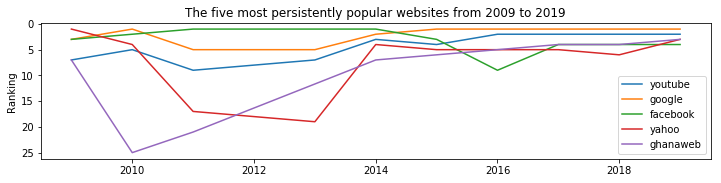

In [647]:
popular = df_top10_wa.stack().value_counts().index[:5]
plotPopular(popular)

#### Eastern Africa

In [648]:
df_top10_ea = topten(df_top10, ea, range(2009,2020))
df_top10_ea

,2009,2010,2011,2014,2015,2016,2017,2018,2019
1,yahoo,google,facebook,google,google,google,google,google,google
2,google,facebook,google,facebook,facebook,youtube,youtube,caasimada,youtube
3,facebook,blogger,yahoo,youtube,yahoo,facebook,facebook,youtube,facebook
4,live,live,youtube,yahoo,youtube,millardayo,yahoo,igihe,igihe
5,msn,msn,blogspot,el-balad,ask,standardmedia,tuko,tuko,standardmedia
6,blogger,tagged,zoomtanzania,twitter,twitter,yahoo,igihe,yahoo,yahoo
7,youtube,bbc,twitter,ask,jumia,igihe,standardmedia,facebook,caasimada
8,wikipedia,yahoo,wikipedia,standardmedia,wikipedia,nation,ask,standardmedia,umuryango
9,tagged,kenyanlyrics,newvision,linkedin,standardmedia,twitter,nation,nation,nation
10,microsoft,about,jamiiforums,wikipedia,nation,ask,millardayo,instagram,live


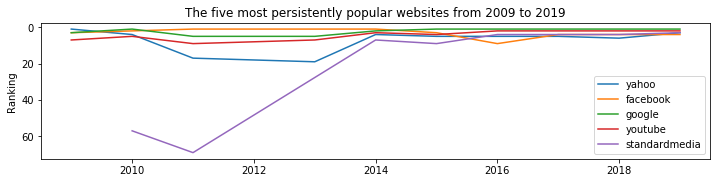

In [649]:
popular = df_top10_ea.stack().value_counts().index[:5]
plotPopular(popular)

#### Northen Africa

In [651]:
df_top10_na = topten(df_top10, na, range(2009,2020))
df_top10_na

,2009,2010,2011,2013,2014,2015,2016,2017,2018,2019
1,facebook,google,facebook,facebook,facebook,facebook,google,youtube,youtube,google
2,google,facebook,google,google,google,google,facebook,google,google,youtube
3,yahoo,yahoo,youtube,youtube,youtube,youtube,youtube,hespress,facebook,chouftv
4,live,youtube,yahoo,yahoo,yahoo,hespress,onclickads,facebook,hespress,ouedkniss
5,youtube,live,live,live,hespress,yahoo,hespress,yahoo,yahoo,facebook
6,maktoob,myegy,maktoob,ouedkniss,ask,ask,yahoo,chouftv,chouftv,speakol
7,msn,msn,hespress,alnilin,amazon,avito,wikipedia,nessma,nessma,hespress
8,kooora,kooora,blogspot,blogspot,blogspot,mosaiquefm,elbalad,albawabhnews,speakol,mosaiquefm
9,rapidshare,maktoob,babylon,ask,avito,alnaharegypt,avito,eskimi,opensooq,yahoo
10,tunisia-sat,echoroukonline,fatakat,alrakoba,live,el-balad,yallakora,ouedkniss,eskimi,live


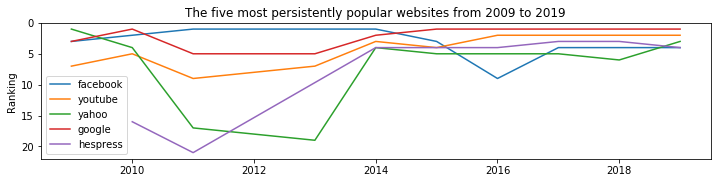

In [652]:
popular = df_top10_na.stack().value_counts().index[:5]
plotPopular(popular)

#### Southern Africa

In [653]:
df_top10_sa = topten(df_top10, sa, range(2009,2020))
df_top10_sa

,2009,2010,2011,2013,2014,2015,2016,2017,2018,2019
1,google,google,google,google,google,google,google,google,google,google
2,live,facebook,facebook,facebook,facebook,facebook,youtube,youtube,youtube,youtube
3,yahoo,yahoo,youtube,youtube,youtube,youtube,facebook,yahoo,zimeye,facebook
4,facebook,youtube,yahoo,yahoo,linkedin,yahoo,yahoo,facebook,facebook,nyasatimes
5,msn,wikipedia,bidorbuy,gumtree,wikipedia,linkedin,live,zimeye,yahoo,nust
6,youtube,gumtree,gumtree,linkedin,yahoo,gumtree,zimeye,times,nust,zimeye
7,wikipedia,twitter,wikipedia,wikipedia,gumtree,twitter,blogspot,nyasatimes,businesslnk,yahoo
8,blogger,blogger,linkedin,amazon,twitter,amazon,alibaba,wikipedia,nyasatimes,nehandaradio
9,uol,live,twitter,bidorbuy,fnb,wikipedia,movitel,uniswa,uniswa,live
10,gumtree,standardbank,blogspot,blogspot,bidorbuy,fnb,fnb,movitel,live,uniswa


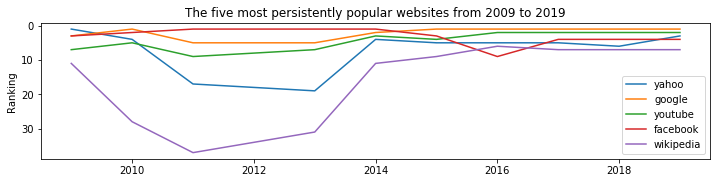

In [654]:
popular = df_top10_sa.stack().value_counts().index[:5]
plotPopular(popular)

#### Central Africa

In [655]:
df_top10_ca = topten(df_top10, ca, range(2009,2020))
df_top10_ca

,2009,2011,2014,2016,2017,2018,2019
1,yahoo,yahoo,yahoo,google,google,google,google
2,google,google,google,youtube,youtube,youtube,youtube
3,live,facebook,facebook,facebook,yahoo,yahoo,yahoo
4,msn,youtube,youtube,yahoo,facebook,facebook,mediacongo
5,facebook,bbc,wikipedia,cpasbien,cpasbien,wikipedia,facebook
6,youtube,badoo,ask,wikipedia,wikipedia,eskimi,wikipedia
7,wikipedia,ebay,cameroon-info,ask,mediacongo,mediacongo,premierbet
8,doubleclick,live,paleba,mediacongo,onclkds,informationvine,seeg-gabon
9,microsoft,wikipedia,blogspot,onclickads,ask,emploi,cpasbiens
10,free,amazon,badoo,jumia,jumia,cameroon-info,gabonreview


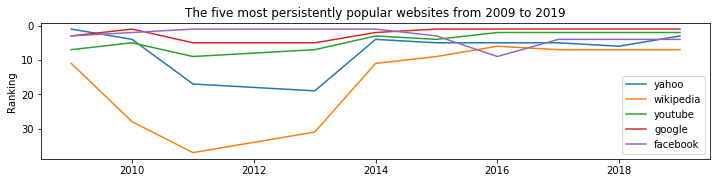

In [656]:
popular = df_top10_ca.stack().value_counts().index[:5]
plotPopular(popular)

#### Indian Ocean

In [657]:
df_top10_io = topten(df_top10, io, range(2009,2020))
df_top10_io

,2009,2010,2011,2015,2016,2017,2018,2019
1,google,facebook,google,google,youtube,google,google,google
2,yahoo,google,facebook,facebook,google,youtube,youtube,youtube
3,skyrock,yahoo,yahoo,youtube,facebook,facebook,facebook,defimedia
4,facebook,live,youtube,yahoo,lexpress,defimedia,defimedia,facebook
5,live,youtube,leboncoin,leboncoin,msn,uptodown,yahoo,lexpress
6,sobika,msn,live,amazon,yahoo,yahoo,lexpress,yahoo
7,msn,moov,moov,diply,leboncoin,lexpress,wikipedia,inside
8,moov,wikipedia,wikipedia,wikipedia,bing,live,leboncoin,wikipedia
9,youtube,skyrock,orange,ask,ask,leboncoin,bongacams,ac-reunion
10,orange,orange,clicanoo,lexpress,ac-reunion,wikipedia,parcoursup,instagram


Let's see which name persisted in the list of top tens over a given period the longest and plot those names.

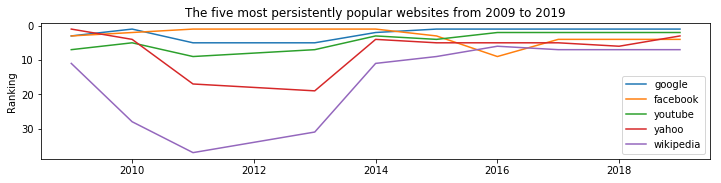

In [658]:
popular = df_top10_io.stack().value_counts().index[:5]
plotPopular(popular)

In [ ]:
toptens('F',1985,1995).stack().value_counts()
